# 1. Einleitung

***
Ziel: Ermittlung der Erfolgsfaktoren von Superhosts im Raum Zürich.
Fragestellung: Was unterscheidet Superhosts von anderen Hosts und welche Massnahmen kann InvestZurich AG ergreifen, um diesen Status zu erreichen?
***

# 2. Datenaufbereitung

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

Laden der Daten

In [2]:
from airbnb_analysis_service import AirbnbAnalysisService

airbnbAnalysis = AirbnbAnalysisService()
# get all tables in form of a list
listings = airbnbAnalysis.get_listings()
listings_df = pd.DataFrame([l.__dict__ for l in listings])

Check form of the Data

In [3]:
listings_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,reviews_per_month,missing_data_flag
0,178448,https://www.airbnb.com/rooms/178448,20241230011608,2024-12-30,city scrape,"a lovely place, top location","Very central location, 5 min walk from Bahnhof...","We live in one of the top locations of Zürich,...",https://a0.muscache.com/pictures/7d41e016-e818...,854016,...,4.89,4.89,5.00,4.89,False,1,0,1,0.06,False
1,227039,https://www.airbnb.com/rooms/227039,20241230011608,2024-12-30,city scrape,*Luxury Penthouse in the heart of trendy Zurich*,Modern and unique penthouse apartment over thr...,Zurich is hip-circuit with the Swiss peacefuln...,https://a0.muscache.com/pictures/c93b46a3-ceb0...,1184427,...,4.97,4.94,4.94,4.84,False,1,1,0,0.19,False
2,310964,https://www.airbnb.com/rooms/310964,20241230011608,2024-12-30,city scrape,Large Apartment - Center of Zurich,None,Many theaters and museums as well as dozins of...,https://a0.muscache.com/pictures/3304245/14d3f...,1266114,...,5.00,4.92,4.85,4.85,False,1,1,0,0.09,False
3,577683,https://www.airbnb.com/rooms/577683,20241230011608,2024-12-30,city scrape,Garden Apartment in Zurich West with private Gym,Welcome to our modern and elegant garden flat ...,very central but never the less quite neighbor...,https://a0.muscache.com/pictures/090331a6-5088...,1240329,...,5.00,4.86,5.00,4.86,False,1,1,0,0.05,False
4,14823254,https://www.airbnb.com/rooms/14823254,20241230011608,2024-12-30,city scrape,"A quiet bedroom, central and cosy",My flat is located in a residential area with...,Very residential.,https://a0.muscache.com/pictures/df1cac9b-dbc0...,67421613,...,4.87,4.87,4.68,4.75,False,3,1,2,1.24,False


In [4]:
cols = [
    'host_is_superhost', 'host_response_time', 'host_response_rate',
    'host_acceptance_rate_percent', 'host_total_listings_count', 'host_has_profile_pic',
    'host_identity_verified', 'room_type', 'accommodates', 'bathrooms',
    'bedrooms', 'beds', 'price', 'minimum_nights', 'number_of_reviews',
    'review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication',
    'review_scores_value', 'instant_bookable', 'availability_365', 'reviews_per_month'
]
listings_df = listings_df[cols].copy()

Konvertierung von Prozentwerten

In [5]:
def convert_percent(x):
    try:
        if isinstance(x, str) and '%' in x:
            return float(x.strip('%')) / 100
        return float(x) / 100
    except:
        return np.nan

listings_df['host_response_rate'] = listings_df['host_response_rate'].apply(convert_percent)
listings_df['host_acceptance_rate_percent'] = listings_df['host_acceptance_rate_percent'].apply(convert_percent)

In [6]:
listings_df[["host_response_rate", "host_acceptance_rate_percent"]].head()

,host_response_rate,host_acceptance_rate_percent
0,1.0,NaN
1,1.0,0.0
2,NaN,NaN
3,1.0,NaN
4,1.0,1.0


Entferne Zeilen mit fehlendem Superhost-Status

In [7]:
listings_df = listings_df[listings_df['host_is_superhost'].notna()]

Superhost Status wird in 0 und 1 umgewandelt

In [8]:
listings_df['host_is_superhost'] = listings_df['host_is_superhost'].astype(str).str.lower().map({'true': 1, 'false': 0, 't': 1, 'f': 0})

In [9]:
print(listings_df['host_is_superhost'].count())

933


Fehlende numerische Werte auffüllen

In [10]:
listings_df.fillna(listings_df.median(numeric_only=True), inplace=True)

In [11]:
for col in ['host_response_time', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'room_type']:
    listings_df[col] = LabelEncoder().fit_transform(listings_df[col].astype(str))

# 3. Explorative Datenanalyse

In [12]:
print("Anzahl Superhosts vs. Nicht-Superhosts:")
print(listings_df['host_is_superhost'].value_counts())
print("\nProzentuale Verteilung:")
print(listings_df['host_is_superhost'].value_counts(normalize=True) * 100)

Anzahl Superhosts vs. Nicht-Superhosts:
host_is_superhost
0    547
1    386
Name: count, dtype: int64

Prozentuale Verteilung:
host_is_superhost
0    58.628081
1    41.371919
Name: proportion, dtype: float64


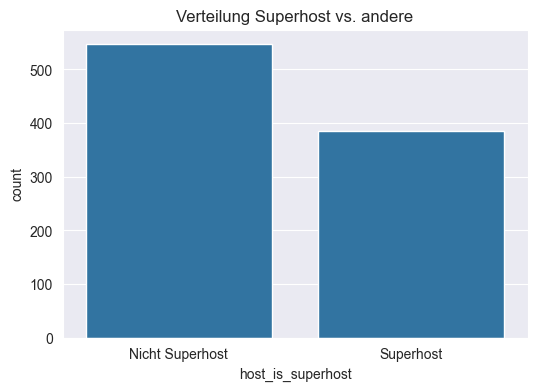

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x='host_is_superhost', data=listings_df)
plt.title("Verteilung Superhost vs. andere")
plt.xticks([0,1], ['Nicht Superhost', 'Superhost'])
plt.show()

# Numerische Differenzierung zwischen Superhosts und Nicht-Superhosts

In [14]:
grouped_stats = listings_df.groupby('host_is_superhost').mean(numeric_only=True).T
print("\nMittelwerte der Merkmale nach Superhost-Status:")
print(grouped_stats.sort_values(by=1, ascending=False))


Mittelwerte der Merkmale nach Superhost-Status:
host_is_superhost                      0           1
availability_365              189.457038  196.917098
price                         193.939671  172.189119
number_of_reviews              51.305302   88.595855
host_total_listings_count      20.308958   61.626943
review_scores_communication     4.796252    4.887876
review_scores_cleanliness       4.653071    4.840622
review_scores_rating            4.687294    4.798731
review_scores_value             4.557824    4.662850
host_response_time              2.531993    3.650259
minimum_nights                  7.246801    3.637306
accommodates                    2.630713    2.909326
beds                            1.484461    1.683938
reviews_per_month               0.862066    1.453212
bathrooms                       1.134369    1.138601
bedrooms                        1.102377    1.090674
host_has_profile_pic            0.994516    1.000000
host_response_rate              0.919689    0.9945

# Optional: Differenzen als Prozentvergleich

In [15]:
diff = (grouped_stats[1] - grouped_stats[0]) / grouped_stats[0] * 100
print("\nProzentuale Differenzen (Superhost vs. Nicht-Superhost):")
print(diff.sort_values(ascending=False))


Prozentuale Differenzen (Superhost vs. Nicht-Superhost):
host_total_listings_count       203.447095
instant_bookable                111.959169
number_of_reviews                72.683625
reviews_per_month                68.573259
host_response_time               44.165466
host_acceptance_rate_percent     25.602105
beds                             13.437683
accommodates                     10.590796
host_response_rate                8.143651
review_scores_cleanliness         4.030681
availability_365                  3.937600
review_scores_rating              2.377411
review_scores_value               2.304285
review_scores_communication       1.910312
host_identity_verified            1.145068
host_has_profile_pic              0.551471
bathrooms                         0.373049
bedrooms                         -1.061618
price                           -11.215112
room_type                       -25.369110
minimum_nights                  -49.808118
dtype: float64


# Visualisierung der Top-Differenzen

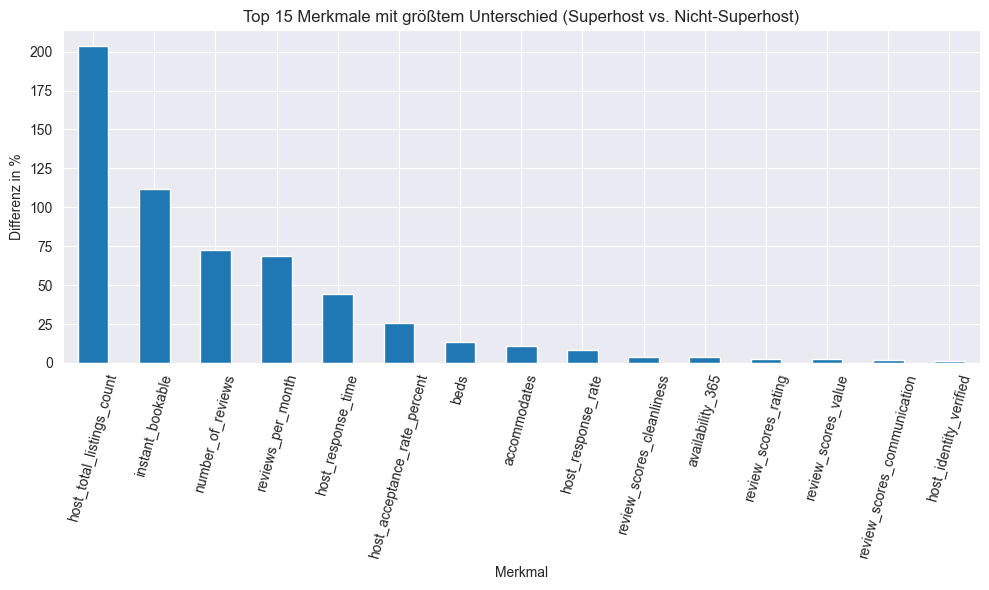

In [16]:
plt.figure(figsize=(10, 6))
diff.sort_values(ascending=False).head(15).plot(kind='bar')
plt.title("Top 15 Merkmale mit größtem Unterschied (Superhost vs. Nicht-Superhost)")
plt.ylabel("Differenz in %")
plt.xlabel("Merkmal")
plt.xticks(rotation=75)
plt.grid(True)
plt.tight_layout()
plt.show()

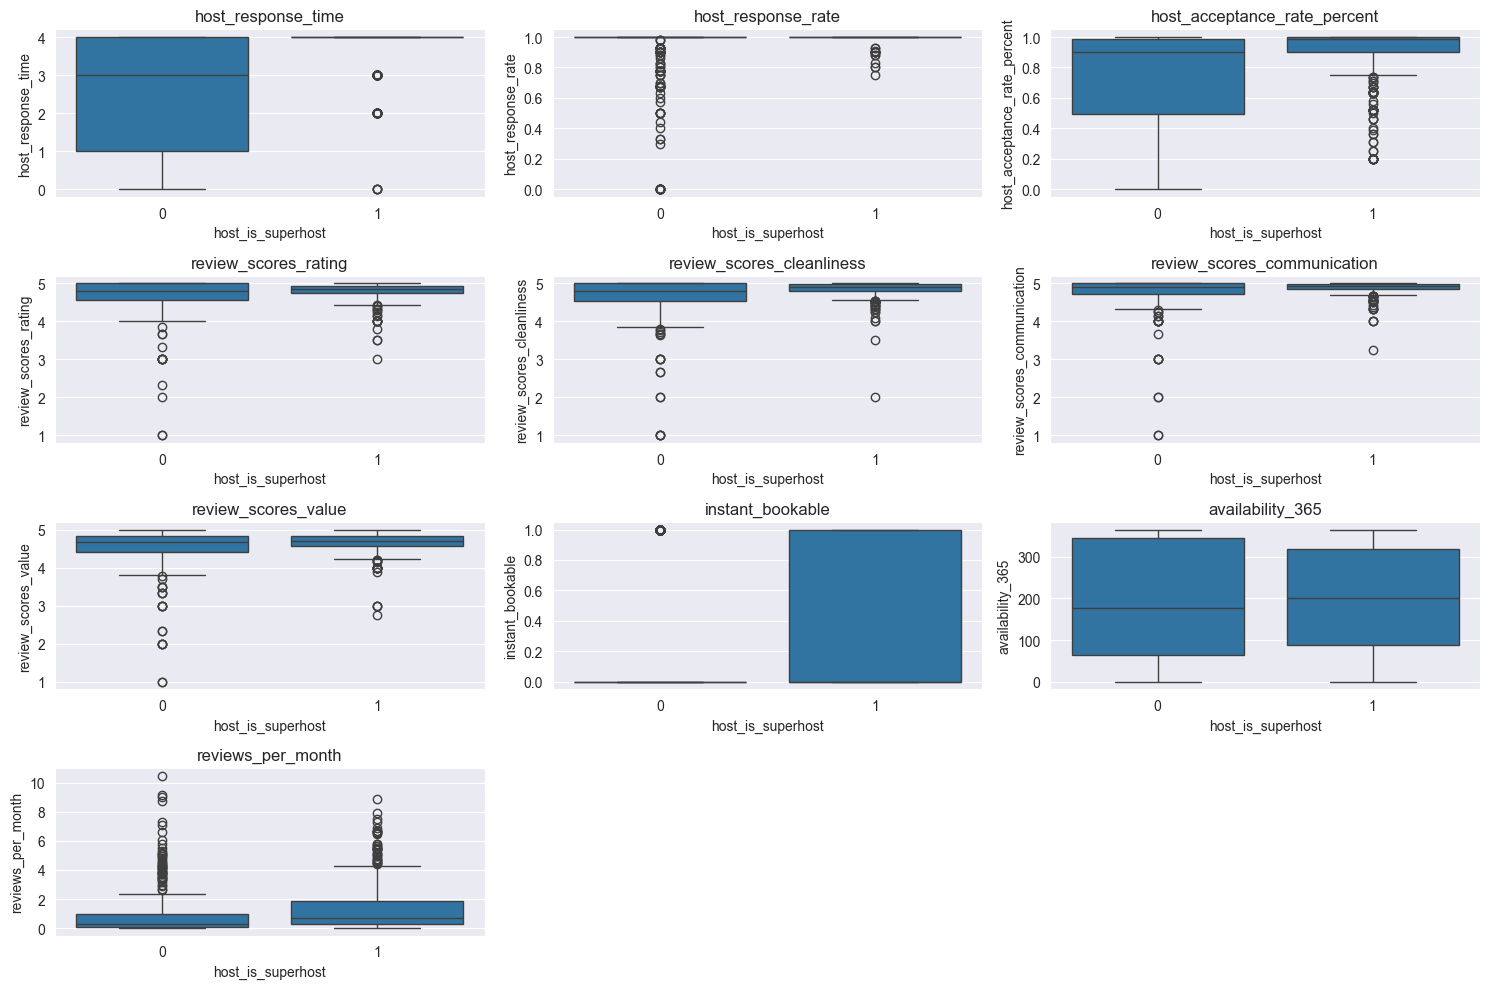

In [17]:
features = ['host_response_time', 'host_response_rate', 'host_acceptance_rate_percent',
            'review_scores_rating', 'review_scores_cleanliness', 'review_scores_communication',
            'review_scores_value', 'instant_bookable', 'availability_365', 'reviews_per_month']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='host_is_superhost', y=feature, data=listings_df)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [18]:
X = listings_df.drop('host_is_superhost', axis=1)
y = listings_df['host_is_superhost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       114
           1       0.91      0.84      0.87        73

    accuracy                           0.90       187
   macro avg       0.91      0.89      0.90       187
weighted avg       0.90      0.90      0.90       187



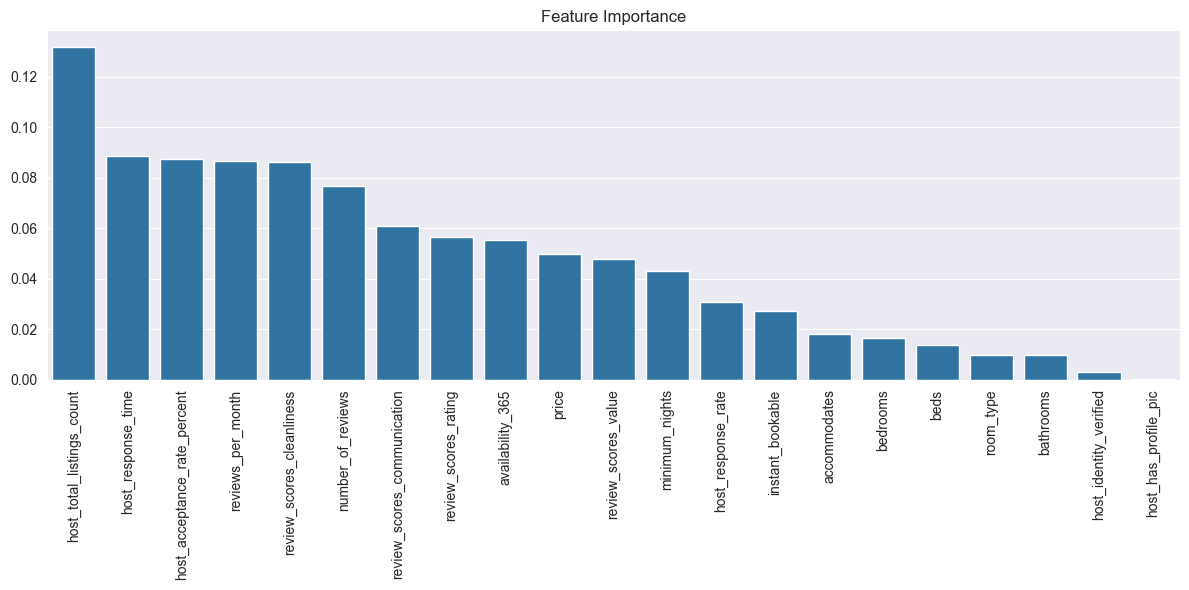

In [19]:
def plot_feature_importance(importance, names):
    plt.figure(figsize=(12, 6))
    indices = np.argsort(importance)[::-1]
    plt.title("Feature Importance")
    sns.barplot(x=np.array(names)[indices], y=importance[indices])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_feature_importance(model.feature_importances_, X.columns)

### Interpretation der Feature-Importanz

Das eingesetzte Machine-Learning-Modell (Random Forest) analysiert, welche Merkmale massgeblich dafür verantwortlich sind, ob ein Airbnb-Host in Zürich den Superhost-Status erreicht.

### Bedeutende Einflussfaktoren:

1. **`host_total_listings_count`**
      Hosts mit mehreren Objekten weisen häufiger den Superhost-Status auf. Dies ist weniger ein Hinweis darauf, dass die Anzahl der vermieteten Wohnungen selbst entscheidend ist, sondern vielmehr darauf, dass diese Hosts Airbnb gewerblich oder zumindest professioneller betreiben. Dadurch sind sie tendenziell besser organisiert und schneiden in anderen relevanten Faktoren wie Reaktionszeit, Buchungsannahme und Gästekommunikation besser ab. Die Korrelation könnte zudem dadurch beeinflusst sein, dass erfahrene Gastgeber sich proaktiver um den Superhost-Status bemühen oder besser mit den Anforderungen der Plattform vertraut sind.

2. **`host_response_time`** und **`host_acceptance_rate_percent`**
   Eine schnelle Reaktion auf Anfragen und eine hohe Annahmequote gelten als zentrale Anforderungen, da sie Verlässlichkeit signalisieren.

3. **`reviews_per_month`** und **`review_scores_cleanliness`**
   Regelmäßige und qualitativ hochwertige Bewertungen, insbesondere im Bereich Sauberkeit, sprechen für ein hohes Serviceniveau.

### Kritische Einordnung:

- Merkmale wie **`host_identity_verified`** oder **`host_has_profile_pic`** tragen im Modell kaum zur Vorhersagekraft bei. Dies kann durch geringe Varianz in diesen Spalten erklärt werden oder darauf hinweisen, dass sie für Gäste keine ausschlaggebende Rolle spielen.

- Die Ausstattung der Unterkunft (z. B. **`beds`**, **`bathrooms`**, **`room_type`**) ist im Zusammenhang mit dem Superhost-Status weniger relevant, was plausibel erscheint – dieser Status bewertet vorrangig das Verhalten des Hosts.

- Der Einfluss von **`price`** ist ebenfalls gering. Daraus lässt sich schließen, dass Preisgestaltung allein nicht entscheidend ist – wichtiger ist das gebotene Preis-Leistungs-Verhältnis.

### Fazit:
Die Analyse bestätigt: Der Superhost-Status hängt weniger von der Ausstattung und dem Preis ab, sondern primär von Engagement, Zuverlässigkeit und Kundenzufriedenheit. Für InvestZurich AG bedeutet dies: operative Exzellenz, transparente Kommunikation und kontinuierlich gute Gästebewertungen sind die wesentlichen Stellschrauben zur Erreichung des Superhost-Status.

# 5. Empfehlungen für InvestZurich AG

- Antwortzeit optimieren: Hosts mit schnellem Antwortverhalten sind häufiger Superhosts.
- Hohe Akzeptanzrate: Über 90% akzeptierte Anfragen sind ein Erfolgsfaktor.
- Hohe Bewertungen in Sauberkeit & Kommunikation sind entscheidend.
- Sofortbuchung aktivieren, wenn möglich.
- Konsistente Verfügbarkeit (365 Tage) kann zu mehr Buchungen führen.
- Regelmässige Reviews fördern (z.B. durch Qualität & Follow-up).

# 6. Fazit

Superhosts zeigen konsistentes Engagement und hohe Qualitätsstandards. Die oben genannten Faktoren lassen sich mit gezielten Massnahmen verbessern.
Ein Machine Learning Modell zeigt eine gute Vorhersageleistung und identifiziert zentrale Hebel für InvestZurich AG.

In [20]:
log_model = LogisticRegression(max_iter=1000000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Logistische Regression - Classification Report:")
print(classification_report(y_test, y_pred_log))

Logistische Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       114
           1       0.65      0.70      0.68        73

    accuracy                           0.74       187
   macro avg       0.73      0.73      0.73       187
weighted avg       0.74      0.74      0.74       187



In [21]:
rf_cv_scores = cross_val_score(model, X, y, cv=5)
print("Random Forest - durchschnittliche CV-Accuracy:", rf_cv_scores.mean())

Random Forest - durchschnittliche CV-Accuracy: 0.8488413547237077


In [22]:
log_cv_scores = cross_val_score(log_model, X, y, cv=5)
print("Logistische Regression - durchschnittliche CV-Accuracy:", log_cv_scores.mean())

Logistische Regression - durchschnittliche CV-Accuracy: 0.7330975792076361


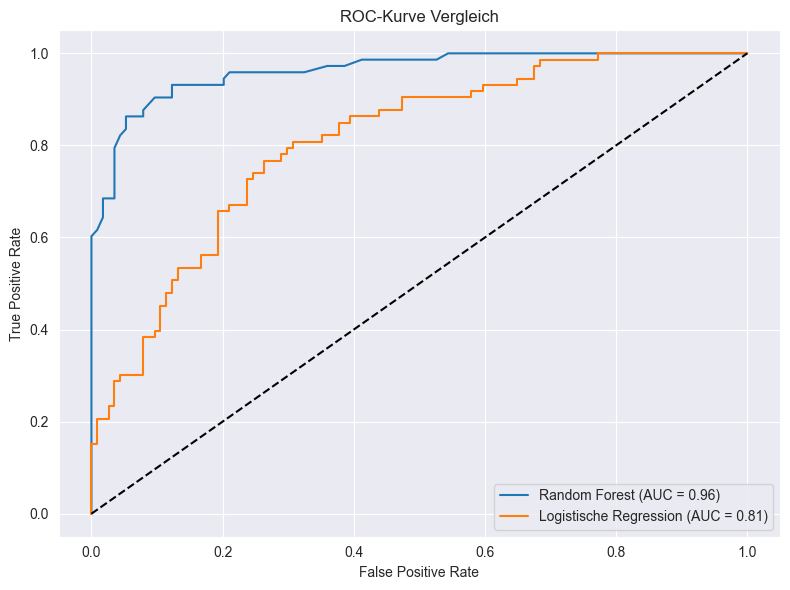

In [23]:
probs_rf = model.predict_proba(X_test)[:, 1]
probs_log = log_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, probs_rf)
fpr_log, tpr_log, _ = roc_curve(y_test, probs_log)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, probs_rf)))
plt.plot(fpr_log, tpr_log, label='Logistische Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, probs_log)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve Vergleich')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Die ROC-Kurve (Receiver Operating Characteristic) vergleicht die Klassifikationsleistung zweier Modelle hinsichtlich ihrer Fähigkeit, zwischen Superhosts und Nicht-Superhosts zu unterscheiden. Dargestellt ist jeweils die True Positive Rate (Empfindlichkeit) gegenüber der False Positive Rate.

- **Random Forest (AUC = 0.96)**: Das Modell weist eine nahezu perfekte Trennschärfe auf. Die Kurve verläuft steil in die linke obere Ecke, was bedeutet, dass das Modell bei minimalen Fehlalarmen (False Positives) bereits viele korrekte Superhosts identifiziert. Der AUC-Wert (Area Under the Curve) von 0.96 signalisiert eine exzellente Modellgüte.

- **Logistische Regression (AUC = 0.81)**: Dieses Modell trennt die Klassen ebenfalls gut, allerdings mit spürbar geringerer Präzision im Vergleich zum Random Forest. Der AUC-Wert liegt bei 0.81, was als solide, aber nicht herausragend gilt.

**Fazit:** Der Random Forest ist dem linearen Vergleichsmodell deutlich überlegen und bietet eine verlässliche Entscheidungsgrundlage für datenbasierte Handlungsempfehlungen zur Identifikation und Förderung potenzieller Superhosts.

## Gesamtfazit und Handlungsempfehlung

Die umfassende Analyse hat gezeigt, dass der Superhost-Status auf Airbnb das Ergebnis eines konsistenten Zusammenspiels aus Gastgeberverhalten, Servicequalität und operativer Professionalität ist. Superhosts unterscheiden sich von anderen Anbietern nicht nur punktuell, sondern durch ein deutlich erkennbares Gesamtprofil: Sie antworten schneller, akzeptieren mehr Anfragen, erhalten bessere Bewertungen und sind insgesamt aktiver und präsenter auf der Plattform.

Die Klassifikationsmodelle – insbesondere der Random Forest – haben diese Zusammenhänge zuverlässig identifiziert und erlauben eine datenbasierte Einschätzung, welche Merkmale für den Superhost-Status entscheidend sind. Dabei zeigen sich sowohl buchungsbezogene Kennzahlen (wie Anzahl Bewertungen, Verfügbarkeit, Buchungsrate) als auch qualitative Aspekte (wie Sauberkeit, Kommunikation, Preis-Leistungs-Verhältnis) als besonders wichtig.

Die Erkenntnisse liefern InvestZurich AG eine klare strategische Richtung:
### Handlungsempfehlung
- Operative Exzellenz sichern: Antwortzeit, Annahmequote und Bewertungsqualität aktiv steuern – z. B. durch klare Prozesse, automatisierte Kommunikation und Schulungen für Gastgeber oder Verwaltungspartner.
- Sichtbarkeit & Aktivität erhöhen: Hohe Objektverfügbarkeit und Sofortbuchung ermöglichen mehr Buchungen und damit mehr Bewertungen – ein zentraler Treiber für den Superhost-Status.
- Monitoring etablieren: Die in dieser Analyse identifizierten KPIs sollten als Teil eines internen Dashboards regelmäßig überwacht werden, um gezielt nachzusteuern.
- Zielgerichtet wachsen: Die Ergebnisse bestätigen, dass professionell betriebene, mehrfach gelistete Objekte systematisch erfolgreicher sind. Skalierung sollte jedoch mit gleichbleibender Servicequalität einhergehen.

Insgesamt zeigen die Ergebnisse: Der Superhost-Status ist keine Frage des Zufalls, sondern das Ergebnis eines strukturierten, qualitätsbewussten Managements.